# BIRCH-based Mondrian Partitioning
This notebook represents the first approach to the BIRCH clustering algorithm to create partitions according to Mondrian's greedy algorithm.

The quasi-identifier columns on which perform clustering at each iteration are choosen randomly. I created this notebook to have some preliminary results and evaluate BIRCH before being implemented in the Mondrian tool belonging to the MOSAICrOWN project.

In [ ]:
%matplotlib inline
from time import time
from itertools import permutations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import Birch
from sklearn.exceptions import ConvergenceWarning
import warnings

       age         workclass  ...  native-country income
0       39         State-gov  ...   United-States  <=50K
1       50  Self-emp-not-inc  ...   United-States  <=50K
2       38           Private  ...   United-States  <=50K
3       53           Private  ...   United-States  <=50K
4       28           Private  ...            Cuba  <=50K
...    ...               ...  ...             ...    ...
32556   27           Private  ...   United-States  <=50K
32557   40           Private  ...   United-States   >50K
32558   58           Private  ...   United-States  <=50K
32559   22           Private  ...   United-States  <=50K
32560   52      Self-emp-inc  ...   United-States   >50K

[32561 rows x 13 columns]


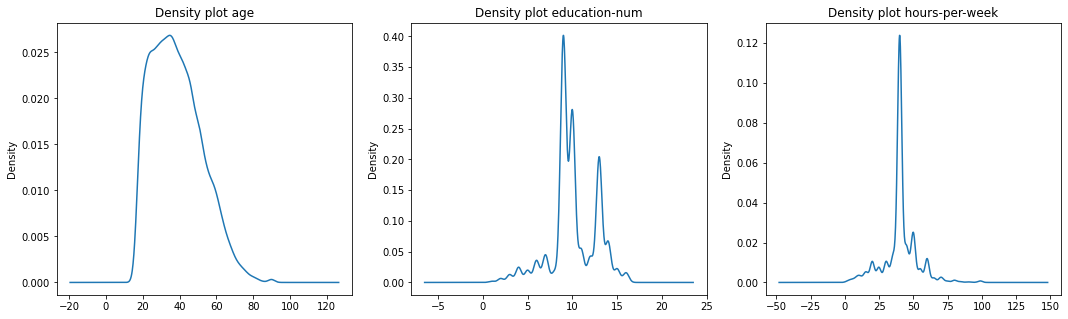

In [ ]:
url = 'https://raw.githubusercontent.com/stegianna/mondrian/master/local/dataset/adults.csv'
df = pd.read_csv(url)

print(df)

age = df['age'].to_numpy()
#print(age)
educd = df['education-num'].to_numpy()
#print(educd)
educd = df['hours-per-week'].to_numpy()
#print(educd)

quasi_id = ['age', 'education-num', 'hours-per-week']
sensitive_col = "income"

plt.figure(figsize=(18,5))
for i, qi in enumerate(quasi_id):
    plt.subplot(1,len(quasi_id),i+1)
    df[qi].plot(kind='density')
    plt.title("Density plot %s" %qi)

plt.show()

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def partitioning(df, min_size, quasi_id, sensitive_col, ldiv, method='median'):
    if method != 'median' and method != 'birch':
        raise Exception(f"{method} method is invalid")
    
    partitions = [df.index]
    result = []
    if method == 'median':
        while partitions:
            perm = list(permutations(quasi_id))
            index = np.random.choice(np.arange(len(perm)))
            columns = list(perm[index])
            part = partitions.pop(0)
            for column in columns:
                dfl, dfr, median = cut_column_median(df[column][part])
                if is_valid(df[column][dfl], min_size, df[sensitive_col][dfl], ldiv) and \
                is_valid(df[column][dfr], min_size, df[sensitive_col][dfr], ldiv):
                    partitions.append(dfl)
                    partitions.append(dfr)
                    break
            else:
                result.append(part)
    elif method == 'birch':
        birch = Birch(n_clusters=2, threshold=0.05)
        while partitions:
            perm = list(permutations(quasi_id))
            index = np.random.choice(np.arange(len(perm)))
            columns = list(perm[index])
            part = partitions.pop(0)
            for column in columns:
                dfl, dfr = cut_column_birch(birch, df[column][part])
                if is_valid(df[column][dfl], min_size, df[sensitive_col][dfl], ldiv) and \
                is_valid(df[column][dfr], min_size, df[sensitive_col][dfr], ldiv):
                    partitions.append(dfl)
                    partitions.append(dfr)
                    break
            else:
                result.append(part)
    return result
        
    
def cut_column_median(ser):
    median = ser.median()
    dfl = ser.index[ser < median]
    dfr = ser.index[ser >= median]
    return (dfl, dfr, median)


def cut_column_birch(birch, ser):
    X = np.reshape(ser.to_numpy(), (-1, 1))
    labels = birch.fit_predict(X)
    dfl = ser.index[labels == 0]
    dfr = ser.index[labels == 1]
    return (dfl, dfr)
        

def is_k_valid(partition, size):
    return len(partition.index) >= size

def is_l_valid(sensitive_col, l):
    return len(set(sensitive_col)) >=l

def is_valid(partition, size, sensitive_col, l):
    return is_k_valid(partition, size) and \
        is_l_valid(sensitive_col, l)


# Metrics Definition
 **Discernability penalty** \\
It is defined as $DP =\sum_{equiv class E} |E|^2$

**Normalized certainty penalty** \\
 Let T be a table with quasi-identifier $(A_1, \dots, A_n)$, where all attributes are numeric. Suppose a tuble $t = (x_1, \dots, t_n)$ is generalized to tuple $t^{'} = ([y_1,z_1], \dots, [y_n,z_n])$ such that $y_i \le x_i \le z_i$. 
 
 On attribute $A_i$ the normalized penalty is defined as 

 $NCP_{A_i}(t) = \frac{z_i-y_i}{|A_i|}$ 
 
where $|A_i| = max_{t \in T}\{t.A_i\} - min_{t \in T} \{t.A_i\}$ is the range of all tubles on attribute $A_i$


In [ ]:
def discernability_penalty(partitions):
    return np.array(list(map(lambda x: len(x)**2, partitions))).sum()

def normalized_certainty_penalty(df, partitions, quasi_id):
    NCP = 0
    for attr in quasi_id:
        max_all = max(df[attr])
        min_all = min(df[attr])
        NCP += sum(list(map(lambda x: (max(df[attr][x])-min(df[attr][x]))/(max_all-min_all)*len(x),partitions)))
    return NCP

def global_certainty_penalty(df, partitions, quasi_id):
    NCP = normalized_certainty_penalty(df, partitions, quasi_id)
    return NCP / (len(quasi_id) * len(df))

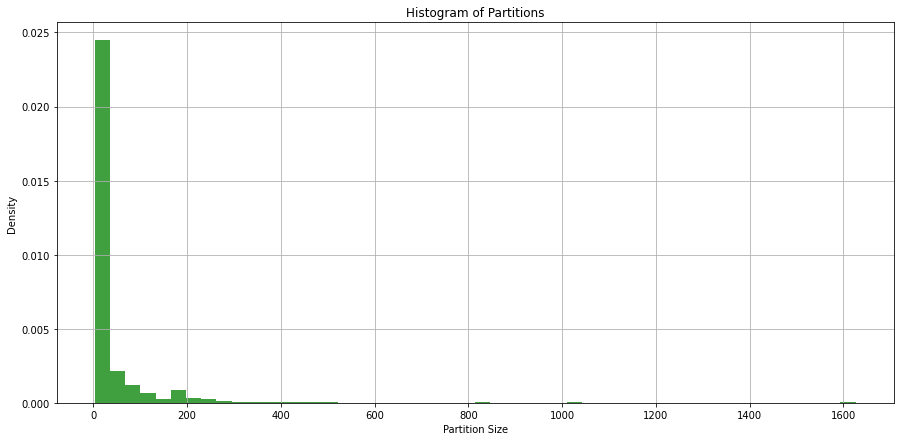

In [ ]:
min_size = 3       #type: int
ldiv = 2           #type: int
method = 'median'  #params ['median', 'birch']

start = time()
partitions = partitioning(df, min_size, quasi_id, sensitive_col, ldiv, method=method)
end = time()

part_size = list(map(len, partitions))
plt.figure(figsize=(15,7))
plt.hist(part_size, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Partition Size')
plt.ylabel('Density')
plt.title('Histogram of Partitions')
plt.grid(True)
plt.show()

In [ ]:
#print(df.iloc[partitions[50], :])
#print(set(df['income']))

In [ ]:
print("Execution time: %.2f seconds" %(end-start))
print("Total partitions:", len(partitions))

print("Discernability penalty = %.2f" %discernability_penalty(partitions))
print("Normalized certainty penalty = %.3f" %normalized_certainty_penalty(df, partitions, quasi_id))
print("Global certainty penalty = %.3f"  %global_certainty_penalty(df, partitions, quasi_id))

print("Number of rows:", sum(part_size))

Execution time: 6.46 seconds
Total partitions: 816
Discernability penalty = 8955097.00
Normalized certainty penalty = 17352.369
Global certainty penalty = 0.178
Number of rows: 32561
